In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from os.path import join
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from core.DiT_model_lib import *
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
from pprint import pprint

saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [3]:
def find_all_ckpt_steps(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if verbose:
        print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
    return sorted(ckpt_steps)


def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def fetch_ref_img_tsr(dataset, ref_img_idx=188):
    """
    Fetch a reference image from the dataset and convert it to a tensor.
    """
    if isinstance(ref_img_idx, int):
        ref_x_raw = dataset[ref_img_idx][0] # 77 is a nice example
    # if it's a iterable, then it's a list of images
    elif isinstance(ref_img_idx, (list, tuple, range, np.ndarray)):
        ref_x_raw = ([dataset[i][0] for i in ref_img_idx])
        ref_x_raw = np.stack(ref_x_raw)
    else:
        raise ValueError(f"Invalid reference image index: {ref_img_idx}")
    ref_x_raw = torch.from_numpy(ref_x_raw).float() / 255.0
    ref_x = (ref_x_raw - 0.5) / 0.5
    return ref_x


In [5]:
from einops import rearrange
def patch_mean_cov(X, P, device='cuda'):
    # X = data_Xtsr[1000:3000].cpu()
    # X = (X - 0.5) / 0.5
    # Y = data_Xtsr[1000:3000].cpu()
    C_out = X.shape[1]
    C_in = X.shape[1]
    # X: (N, C_in, H, W), Y: (N, C_out, H_out, W_out)
    unfold = torch.nn.Unfold(kernel_size=P, padding=P//2, stride=1)
    X_patches = unfold(X)
    print(X_patches.shape)
    # n_samples, n_patch_elements, n_positions = X_patches.shape
    X_patches_flatten = rearrange(X_patches, "n_sample n_element n_position -> (n_sample n_position) n_element").to(device)
    patch_mean = X_patches_flatten.mean(dim=0)
    patch_cov = torch.cov(X_patches_flatten.T).to(device)  # Transpose to get n_element by n_element covariance matrix
    return patch_mean, patch_cov


def patch_Gaussian_denoiser(patch_mean, patch_cov, noise_level, P, C_in, device='cuda'):
    sigma = noise_level
    eye_mat = torch.eye(patch_cov.shape[0], device=device)
    patch_cov = patch_cov.to(device)
    patch_mean = patch_mean.to(device)
    denoiser_jacobian = patch_cov @ torch.linalg.inv(patch_cov + eye_mat * sigma ** 2)
    denoiser_bias = (eye_mat - denoiser_jacobian) @ patch_mean
    W_center = denoiser_jacobian.view(C_in, P, P, C_in, P, P)[:, P//2, P//2, :, :, :]
    b_center = denoiser_bias.view(C_in, P, P)[:, P//2, P//2]
    print(W_center.shape)
    print(b_center.shape)
    return denoiser_jacobian, denoiser_bias, W_center, b_center


def compute_patch_Gaussian_denoiser(data_Xtsr, P, noise_level, device='cuda'):
    C_in = data_Xtsr.shape[1]
    print("Computing patch mean and covariance")
    patch_mean, patch_cov = patch_mean_cov(data_Xtsr, P, device="cpu")
    print("Computing patch Gaussian denoiser")
    denoiser_jacobian, denoiser_bias, W_center, b_center = patch_Gaussian_denoiser(patch_mean, patch_cov, noise_level, P, C_in, device=device)
    return denoiser_jacobian, denoiser_bias, W_center, b_center


def build_linear_conv_denoiser_layer(patch_mean, patch_cov, noise_level, P, C_in, device='cuda'):
    print("Computing patch Gaussian denoiser")
    denoiser_jacobian, denoiser_bias, W_center, b_center = patch_Gaussian_denoiser(patch_mean, patch_cov, noise_level, P, C_in, device=device)
    conv_GaussianPatch = torch.nn.Conv2d(C_in, C_out, kernel_size=P, padding=P//2, stride=1)
    conv_GaussianPatch.weight.data = W_center
    conv_GaussianPatch.bias.data = b_center
    return conv_GaussianPatch


In [6]:
import sys
from os.path import join
sys.path.append("/n/home12/binxuwang/Github/edm")
from training.dataset import TensorDataset, ImageFolderDataset
edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
dataset = ImageFolderDataset(edm_ffhq64_path)

### Playground for demo the linear conv denoisr

In [17]:
Xtsr64_1000 = fetch_ref_img_tsr(dataset, range(1000))
P = 15
noise_level = 5.0
device = "cpu"
X = Xtsr64_1000
C_out = X.shape[1]
C_in = X.shape[1]
# X: (N, C_in, H, W), Y: (N, C_out, H_out, W_out)
unfold = torch.nn.Unfold(kernel_size=P, padding=P//2, stride=1)
X_patches = unfold(X)
print(X_patches.shape)
# n_samples, n_patch_elements, n_positions = X_patches.shape
X_patches_flatten = rearrange(X_patches, "n_sample n_element n_position -> (n_sample n_position) n_element").to(device)
patch_mean = X_patches_flatten.mean(dim=0)
patch_cov = torch.cov(X_patches_flatten.T).to(device)  # Transpose to get n_element by n_element covariance matrix
# denoiser_jacobian, denoiser_bias, W_center, b_center = compute_patch_Gaussian_denoiser(Xtsr64_1000, P, noise_level, device='cpu')
train_patche_bank = X_patches_flatten.to(torch.float16).cuda()

torch.Size([1000, 675, 4096])


In [18]:
linconv_denoiser_dict = {}
for noise_level in [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 3.5, 5.0, 10.0, 50.0]:
    denoiser_jacobian, denoiser_bias, W_center, b_center = patch_Gaussian_denoiser(patch_mean, patch_cov, noise_level, P, C_in, device=device)
    # denoiser_jacobian, denoiser_bias, W_center, b_center = compute_patch_Gaussian_denoiser(Xtsr64_1000, P, noise_level, device='cpu')
    # build conv model
    conv_GaussianPatch = torch.nn.Conv2d(C_in, C_out, kernel_size=P, padding=P//2, stride=1)
    conv_GaussianPatch.weight.data = W_center
    conv_GaussianPatch.bias.data = b_center
    linconv_denoiser_dict[noise_level] = conv_GaussianPatch

torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])
torch.Size([3, 3, 15, 15])
torch.Size([3])


In [ ]:
conv_GaussianPatch

In [26]:

sigma = noise_level
eye_mat = torch.eye(patch_cov.shape[0], device=device)
patch_cov = patch_cov.to(device)
patch_mean = patch_mean.to(device)
eigval, eigvec = torch.linalg.eigh(patch_cov)
denoiser_jacobian = eigvec @ torch.diag(eigval / (eigval + sigma ** 2)) @ eigvec.T
desnoiser_bias = eigvec @ torch.diag(sigma ** 2 / (eigval + sigma ** 2)) @ eigvec.T @ patch_mean
denoiser_jacobian_orig = patch_cov @ torch.linalg.inv(patch_cov + eye_mat * sigma ** 2)
denoiser_bias_orig = (eye_mat - denoiser_jacobian) @ patch_mean
assert torch.allclose(denoiser_jacobian, denoiser_jacobian_orig, atol=1e-5)
assert torch.allclose(desnoiser_bias, denoiser_bias_orig, atol=1e-5)
W_center = denoiser_jacobian.view(C_in, P, P, C_in, P, P)[:, P//2, P//2, :, :, :]
b_center = denoiser_bias.view(C_in, P, P)[:, P//2, P//2]
conv_GaussianPatch = torch.nn.Conv2d(C_in, C_out, kernel_size=P, padding=P//2, stride=1)
conv_GaussianPatch.weight.data = W_center
conv_GaussianPatch.bias.data = b_center

In [28]:
sigma = noise_level
eye_mat = torch.eye(patch_cov.shape[0], device=device)
patch_cov = patch_cov.to(device)
patch_mean = patch_mean.to(device)

# Reshape tensors to identify center indices
patch_shape = (C_in, P, P)
center_idx = P // 2
total_elements = C_in * P * P

# Create index masks for the center pixel
# Create a mask for center pixels across all channels
center_mask = torch.zeros(patch_shape, dtype=torch.bool, device=device)
center_mask[:, P // 2, P // 2] = True
center_mask = center_mask.flatten()
# Compute eigendecomposition
eigval, eigvec = torch.linalg.eigh(patch_cov)
# Compute denoiser components
# denoiser_jacobian = eigvec @ torch.diag(eigval / (eigval + sigma ** 2)) @ eigvec.T
# denoiser_bias = eigvec @ torch.diag(sigma ** 2 / (eigval + sigma ** 2)) @ eigvec.T @ patch_mean
W_center_eig = eigvec[center_mask, :] @ torch.diag(eigval / (eigval + sigma ** 2)) @ eigvec.T
b_center_eig = eigvec[center_mask, :] @ torch.diag(sigma ** 2 / (eigval + sigma ** 2)) @ eigvec.T @ patch_mean
W_center_eig = W_center_eig.view(C_in, C_in, P, P)
b_center_eig = b_center_eig.view(C_in,)
# Verification with original formula
denoiser_jacobian_orig = patch_cov @ torch.linalg.inv(patch_cov + eye_mat * sigma ** 2)
denoiser_bias_orig = (eye_mat - denoiser_jacobian) @ patch_mean
assert torch.allclose(denoiser_jacobian, denoiser_jacobian_orig, atol=1e-5)
assert torch.allclose(denoiser_bias, denoiser_bias_orig, atol=1e-5)
W_center = denoiser_jacobian.view(C_in, P, P, C_in, P, P)[:, P//2, P//2, :, :, :]
b_center = denoiser_bias.view(C_in, P, P)[:, P//2, P//2]

assert torch.allclose(W_center, W_center_eig, atol=1e-5)
assert torch.allclose(b_center, b_center_eig, atol=1e-5)
# Create convolutional layer
conv_GaussianPatch = torch.nn.Conv2d(C_in, C_out, kernel_size=P, padding=P//2, stride=1)
conv_GaussianPatch.weight.data = W_center
conv_GaussianPatch.bias.data = b_center

In [ ]:
sigma = noise_level
eye_mat = torch.eye(patch_cov.shape[0], device=device)
patch_cov = patch_cov.to(device)
patch_mean = patch_mean.to(device)

# Reshape tensors to identify center indices
patch_shape = (C_in, P, P)
center_idx = P // 2
total_elements = C_in * P * P

# Create index masks for the center pixel
# Create a mask for center pixels across all channels
center_mask = torch.zeros(patch_shape, dtype=torch.bool, device=device)
center_mask[:, P // 2, P // 2] = True
center_mask = center_mask.flatten()
# Compute eigendecomposition
eigval, eigvec = torch.linalg.eigh(patch_cov)
# Compute denoiser components
# denoiser_jacobian = eigvec @ torch.diag(eigval / (eigval + sigma ** 2)) @ eigvec.T
# denoiser_bias = eigvec @ torch.diag(sigma ** 2 / (eigval + sigma ** 2)) @ eigvec.T @ patch_mean
W_center_eig = eigvec[center_mask, :] @ torch.diag(eigval / (eigval + sigma ** 2)) @ eigvec.T
b_center_eig = eigvec[center_mask, :] @ torch.diag(sigma ** 2 / (eigval + sigma ** 2)) @ eigvec.T @ patch_mean
W_center_eig = W_center_eig.view(C_in, C_in, P, P)
b_center_eig = b_center_eig.view(C_in,)
# Create convolutional layer
conv_GaussianPatch = torch.nn.Conv2d(C_in, C_out, kernel_size=P, padding=P//2, stride=1)
conv_GaussianPatch.weight.data = W_center_eig
conv_GaussianPatch.bias.data = b_center_eig

### Single Noise scale adaptive denoising version

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianPatchFilter(nn.Module):
    def __init__(self, patch_cov: torch.Tensor, patch_mean: torch.Tensor, C_in: int, P: int):
        """
        Args:
            patch_cov: Tensor of shape (C_in*P*P, C_in*P*P), the full patch covariance.
            patch_mean: Tensor of shape (C_in*P*P,), the flattened patch-mean.
            C_in:      Number of input channels.
            P:         Patch spatial size (patch is C_in x P x P).
        """
        super().__init__()
        M = C_in * P * P
        assert patch_cov.shape == (M, M)
        assert patch_mean.numel() == M

        self.C_in = C_in
        self.P = P

        # store mean
        self.register_buffer('patch_mean_flat', patch_mean.view(M))

        # precompute eigendecomposition of the patch covariance
        eigval, eigvec = torch.linalg.eigh(patch_cov)
        self.register_buffer('eigval', eigval)      # (M,)
        self.register_buffer('eigvec', eigvec)      # (M,M)

        # build a mask that picks out the center pixel (for each channel) in the flattened patch
        center_idx = P // 2
        mask = torch.zeros(M, dtype=torch.bool, device=patch_cov.device)
        mask[:, center_idx, center_idx] = True
        self.register_buffer('center_mask', mask)    # (M,)

    def to(self, device):
        self.patch_mean_flat = self.patch_mean_flat.to(device)
        self.eigval = self.eigval.to(device)
        self.eigvec = self.eigvec.to(device)
        self.center_mask = self.center_mask.to(device)
        return self
    
    def forward(self, x: torch.Tensor, noise_level: float) -> torch.Tensor:
        """
        Args:
            x:           Input tensor of shape (B, C_in, H, W).
            noise_level: Scalar noise σ at which to build the filter.
        Returns:
            Tensor of shape (B, C_in, H, W), after applying the adaptive Gaussian patch filter.
        """
        σ2 = noise_level ** 2
        # build the two spectral coefficients
        denom = self.eigval + σ2                     # (M,)
        α = self.eigval / denom                      # (M,)  → denoiser Jacobian spectrum
        β =   σ2   / denom                           # (M,)  → denoiser bias spectrum
        # select only the center rows of eigvec  →  shape (C_in, M)
        Vc = self.eigvec[self.center_mask, :]         # (C_in, M)
        # build the convolutional weight matrix for the center pixel:
        #   Wc = Vc @ diag(α) @ Vᵀ   →  shape (C_in, M)
        Wc_flat = Vc @ (α.unsqueeze(0) * self.eigvec.T)   # (C_in, M)
        # build the center bias:
        #   bc = Vc @ diag(β) @ Vᵀ @ mean_flat   →  (C_in,)
        bc = Vc @ ((β.unsqueeze(0) * self.eigvec.T) @ self.patch_mean_flat)  # (C_in,)
        # reshape weight into conv2d kernel shape: (out_channels, in_channels, P, P)
        W = Wc_flat.view(self.C_in, self.C_in, self.P, self.P)
        # apply convolution
        return F.conv2d(x, weight=W, bias=bc, padding=self.P // 2, stride=1)

In [31]:
eigvec.shape

torch.Size([675, 675])

### Batch multi noise scale denoiser

In [ ]:
eigen_dim = len(eigval)
# first use eigvec denoiser to get the eigen_dim
conv_eigvec = torch.nn.Conv2d(C_in, eigen_dim, kernel_size=P, padding=P//2, stride=1)
conv_eigvec.weight.data = eigvec.T.view(-1, C_in, P, P)
conv_eigvec.bias.data = - eigvec.T @ patch_mean

In [42]:
sigma_vec = torch.exp(torch.randn(5))
eigrepr = conv_eigvec(Xtsr64_1000[0:5],)
print(eigrepr.shape)
print(sigma_vec)
print(eigval.shape)
adaptive_eigval_multiplier = eigval[None, :] / (sigma_vec[:, None] ** 2 + eigval[None, :])
print(adaptive_eigval_multiplier.shape)
shrinkaged_eigrepr = adaptive_eigval_multiplier[:, :, None, None] * eigrepr
shrinkaged_eigrepr.shape

torch.Size([5, 675, 64, 64])
tensor([7.3823, 1.8835, 0.8110, 0.6146, 0.7629])
torch.Size([675])


torch.Size([5, 675, 64, 64])

In [45]:
eigvec_center = eigvec[center_mask, :]
mean_center = patch_mean[center_mask]
print(eigvec_center.shape)
print(mean_center.shape)
readout_conv = torch.nn.Conv2d(eigen_dim, C_out, kernel_size=1, padding=0, stride=1)
readout_conv.weight.data = eigvec_center.view(C_out, eigen_dim, 1, 1)
readout_conv.bias.data = mean_center
denoised_X = readout_conv(shrinkaged_eigrepr)
print(denoised_X.shape)

torch.Size([3, 675])
torch.Size([3])
torch.Size([5, 3, 64, 64])


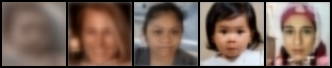

In [48]:
to_imgrid((denoised_X.cpu()*0.5 + 0.5).clamp(0, 1), nrow=5)

In [ ]:
eigen_dim = len(eigval)
center_mask = torch.zeros(C_in, P, P, dtype=torch.bool, device=device)
center_mask[:, P//2, P//2] = True
center_mask = center_mask.flatten()
# first use eigvec denoiser to get the eigen_dim
conv_eigvec = torch.nn.Conv2d(C_in, eigen_dim, kernel_size=P, padding=P//2, stride=1)
conv_eigvec.weight.data = eigvec.T.view(-1, C_in, P, P)
conv_eigvec.bias.data = - eigvec.T @ patch_mean
eigvec_center = eigvec[center_mask, :]
mean_center = patch_mean[center_mask]
print(eigvec_center.shape)
print(mean_center.shape)
readout_conv = torch.nn.Conv2d(eigen_dim, C_out, kernel_size=1, padding=0, stride=1)
readout_conv.weight.data = eigvec_center.view(C_out, eigen_dim, 1, 1)
readout_conv.bias.data = mean_center


eigrepr = conv_eigvec(Xtsr64_1000[0:5],)
adaptive_eigval_multiplier = eigval[None, :] / (sigma_vec[:, None] ** 2 + eigval[None, :])
print(adaptive_eigval_multiplier.shape)
shrinkaged_eigrepr = adaptive_eigval_multiplier[:, :, None, None] * eigrepr
print(shrinkaged_eigrepr.shape)
denoised_X = readout_conv(shrinkaged_eigrepr)
print(denoised_X.shape)

### Function version of Adaptive Gaussian denoiser

In [24]:
import torch
import torch.nn as nn

class AdaptiveGaussianDenoiser(nn.Module):
    def __init__(self,
                 eigvec: torch.Tensor,     # shape (C_in*P*P, eigen_dim)
                 eigval: torch.Tensor,     # shape (eigen_dim,)
                 patch_mean: torch.Tensor,  # shape (C_in*P*P,)
                 patch_size: int):
        """
        eigvec:       eigenvectors of patch covariance, flattened rows, columns as eigen vector
        eigval:       eigenvalues of patch covariance
        patch_mean:   mean vector of each patch entry
        patch_size:   spatial size P of each patch (P x P)
        """
        super().__init__()
        device = eigvec.device
        self.register_buffer('eigval', eigval)
        self.eigen_dim = eigval.numel()
        self.P = patch_size
        
        # infer C_in and C_out from shapes
        total_entries = patch_mean.numel()
        C_in = total_entries // (self.P**2)
        C_out = C_in
        self.C_in = C_in
        self.C_out = C_out
        # 1) conv to project input patches onto eigen-basis
        self.conv_eigvec = nn.Conv2d(
            in_channels=C_in,
            out_channels=self.eigen_dim,
            kernel_size=self.P,
            padding=self.P//2,
            bias=True
        )
        # set weights = eigvec.T reshaped, bias = -eigvec.T @ patch_mean
        self.conv_eigvec.weight.data = eigvec.T.view(
            self.eigen_dim, C_in, self.P, self.P
        )
        self.conv_eigvec.bias.data = - (eigvec.T @ patch_mean)
        # freeze these parameters
        for param in (self.conv_eigvec.weight, self.conv_eigvec.bias):
            param.requires_grad_(False)

        # 2) conv to read out only the center pixel projection
        # build a mask that picks the center location in each flattened row
        center_mask = torch.zeros(C_in, self.P, self.P, dtype=torch.bool, device=device)
        center_mask[:, self.P//2, self.P//2] = True
        center_mask   = center_mask.view(-1)          # shape (C_in*P*P,)
        eigvec_center = eigvec[center_mask, :]        # (C_out, eigen_dim)
        mean_center   = patch_mean[center_mask]       # (C_out,)
        self.readout_conv = nn.Conv2d(
            in_channels=self.eigen_dim,
            out_channels=C_out,
            kernel_size=1,
            bias=True
        )
        self.readout_conv.weight.data = eigvec_center.view(
            C_out, self.eigen_dim, 1, 1
        )
        self.readout_conv.bias.data = mean_center
        for param in (self.readout_conv.weight, self.readout_conv.bias):
            param.requires_grad_(False)

    def forward(self, x: torch.Tensor, sigma_vec: torch.Tensor) -> torch.Tensor:
        """
        x:           (batch, C_in, H, W)
        sigma_vec:   (batch,) noise level for each sample
        returns:     (batch, C_out, H, W) denoised output
        """
        sigma_vec = sigma_vec.view(-1)
        # project onto eigen-space
        eigrepr = self.conv_eigvec(x)  # shape (B, eigen_dim, H, W)
        # compute per-sample shrinkage factors
        # shape (B, eigen_dim)
        shrink_factors = self.eigval[None, :] / (sigma_vec[:, None]**2 + self.eigval[None, :])
        # reshape to broadcast over spatial dims: (B, eigen_dim, 1, 1)
        shrink_factors = shrink_factors[..., None, None]
        # apply shrinkage in eigen-space
        shr_eigrepr = eigrepr * shrink_factors
        # reconstruct only center pixel outputs
        out = self.readout_conv(shr_eigrepr)  # (B, C_out, H, W)
        return out

In [8]:
def compute_mean_cov_eigen(X, P, out_device="cuda"):
    unfold = torch.nn.Unfold(kernel_size=P, padding=P//2, stride=1)
    X_patches = unfold(X)
    print(X_patches.shape)
    X_patches_flatten = rearrange(X_patches, "n_sample n_element n_position -> (n_sample n_position) n_element").to(device)
    print(X_patches_flatten.shape)
    patch_mean = X_patches_flatten.mean(dim=0)
    patch_cov = torch.cov(X_patches_flatten.T).to(device)
    eigval, eigvec = torch.linalg.eigh(patch_cov.cuda())
    return patch_mean.to(out_device), patch_cov.to(out_device), eigval.to(out_device), eigvec.to(out_device)

In [10]:
Xtsr64_1000 = fetch_ref_img_tsr(dataset, range(1000))
P = 15
device = "cpu"

X = Xtsr64_1000
C_out = X.shape[1]
C_in = X.shape[1]
# X: (N, C_in, H, W), Y: (N, C_out, H_out, W_out)
unfold = torch.nn.Unfold(kernel_size=P, padding=P//2, stride=1)
X_patches = unfold(X)
print(X_patches.shape)
# n_samples, n_patch_elements, n_positions = X_patches.shape
X_patches_flatten = rearrange(X_patches, "n_sample n_element n_position -> (n_sample n_position) n_element").to(device)
patch_mean = X_patches_flatten.mean(dim=0)
patch_cov = torch.cov(X_patches_flatten.T).to(device)
eigval, eigvec = torch.linalg.eigh(patch_cov.cuda())

torch.Size([1000, 675, 4096])


In [13]:
P = 15
patch_mean, patch_cov, eigval, eigvec = compute_mean_cov_eigen(Xtsr64_1000[0:1000], P)

torch.Size([1000, 675, 4096])
torch.Size([4096000, 675])


In [ ]:
adaptive_denoiser = AdaptiveGaussianDenoiser(eigvec, eigval, patch_mean, P)

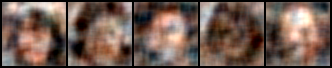

In [18]:
# sigma_vec = torch.exp(torch.randn(5))
sigma_vec = 3 * torch.ones(5)
X_orig = fetch_ref_img_tsr(dataset, range(2000, 2005))
X_noisy = X_orig + torch.randn_like(X_orig) * sigma_vec[:, None, None, None]

denoised_X = adaptive_denoiser(X_noisy.cuda(), sigma_vec.cuda())
denoised_X_pp = (denoised_X.cpu() * 0.5 + 0.5).clamp(0, 1)
display(to_imgrid(denoised_X_pp.cpu(), nrow=5))

In [20]:
noise_level = 3
conv_GaussianPatch = build_linear_conv_denoiser_layer(patch_mean, patch_cov, noise_level, P, C_in, device='cuda')

Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])


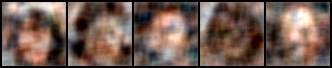

In [21]:
denoised_X_linconv = conv_GaussianPatch(X_noisy.cuda())
denoised_X_linconv_pp = (denoised_X_linconv.cpu() * 0.5 + 0.5).clamp(0, 1)
display(to_imgrid(denoised_X_linconv_pp.cpu(), nrow=5))

In [34]:
assert torch.allclose(denoised_X, denoised_X_linconv, atol=1e-3, rtol=1e-3)
assert torch.allclose(denoised_X_pp, denoised_X_linconv_pp, atol=1e-4, rtol=1e-4)

### Put Linear conv ansatz into the Diffusion CNN

In [46]:
class EDMCNNPrecondLinConvComposeWrapper(nn.Module):
    def __init__(self, model, conv_denoiser, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0):
        super().__init__()
        self.model = model
        self.conv_denoiser = conv_denoiser
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        
    def forward(self, X, sigma, cond=None, ):
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        with torch.no_grad():
            patch_denoised_X = self.conv_denoiser(X, sigma)
        model_out = self.model(c_in * patch_denoised_X, c_noise.view(-1), cond=cond) # this is required for EDM Unet model. 
        return c_skip * X + c_out * model_out
    
    

class EDMCNNPrecondLinConvAddWrapper(nn.Module):
    def __init__(self, model, conv_denoiser, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0):
        super().__init__()
        self.model = model
        self.conv_denoiser = conv_denoiser
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        
    def forward(self, X, sigma, cond=None, ):
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        with torch.no_grad():
            patch_denoised_X = self.conv_denoiser(X, sigma)
        model_out = self.model(c_in * X, c_noise.view(-1), cond=cond) # this is required for EDM Unet model. 
        return c_skip * X + c_out * model_out + patch_denoised_X # TODO: determine is there is a scaling term here. 



class EDMCNNPrecondLinConvAddNoSkipWrapper(nn.Module):
    def __init__(self, model, conv_denoiser, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0):
        super().__init__()
        self.model = model
        self.conv_denoiser = conv_denoiser
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        
    def forward(self, X, sigma, cond=None, ):
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        with torch.no_grad():
            patch_denoised_X = self.conv_denoiser(X, sigma)
        model_out = self.model(c_in * X, c_noise.view(-1), cond=cond) # this is required for EDM Unet model. 
        return c_out * model_out + patch_denoised_X # TODO: determine is there is a scaling term here. 

In [11]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
linconv_dir = join(savedir, "linconv_results")
os.makedirs(linconv_dir, exist_ok=True)
config = edict(json.load(open(f"{savedir}/config.json")))

In [15]:
edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
# if dataset_name == "FFHQ":
edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
dataset = ImageFolderDataset(edm_ffhq64_path)
imgsize = 64
imgchannels = 3
Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0

In [16]:
device = "cuda"#get_device()
Xtsr = (Xtsr_raw.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
imgshape = Xtsr.shape[1:]
ndim = pnts.shape[1]

In [37]:
torch.cuda.empty_cache()

In [ ]:
P = 15
# conv_denoiser = build_linear_conv_denoiser_layer(patch_mean, patch_cov, noise_level, P, C_in, device='cuda')
patch_mean, patch_cov, eigval, eigvec = compute_mean_cov_eigen(Xtsr[0:1000].cpu(), P, out_device='cuda')

torch.Size([1000, 675, 4096])
torch.Size([4096000, 675])


NameError: name 'C_out' is not defined

In [41]:
adaptive_denoiser = AdaptiveGaussianDenoiser(eigvec, eigval, patch_mean, P)

In [33]:
eigval

tensor([1.2274e-05, 1.7596e-05, 2.8527e-05, 3.4511e-05, 3.6847e-05, 4.2101e-05,
        4.2105e-05, 4.3146e-05, 4.9854e-05, 5.0273e-05, 5.0478e-05, 5.1111e-05,
        6.1066e-05, 6.2228e-05, 6.2770e-05, 6.8433e-05, 6.8644e-05, 6.8762e-05,
        7.0666e-05, 7.5047e-05, 7.7297e-05, 7.9550e-05, 8.1993e-05, 8.3597e-05,
        8.4860e-05, 8.9208e-05, 9.1068e-05, 9.1289e-05, 9.4974e-05, 9.5345e-05,
        9.8083e-05, 9.9974e-05, 1.0375e-04, 1.0412e-04, 1.0775e-04, 1.0784e-04,
        1.0814e-04, 1.0902e-04, 1.1132e-04, 1.1591e-04, 1.1858e-04, 1.2106e-04,
        1.2333e-04, 1.2759e-04, 1.2788e-04, 1.2900e-04, 1.2945e-04, 1.3605e-04,
        1.3675e-04, 1.3794e-04, 1.3797e-04, 1.3837e-04, 1.3882e-04, 1.3882e-04,
        1.4026e-04, 1.4119e-04, 1.4239e-04, 1.4337e-04, 1.4497e-04, 1.5140e-04,
        1.5190e-04, 1.5280e-04, 1.5283e-04, 1.5326e-04, 1.6424e-04, 1.6474e-04,
        1.7168e-04, 1.7401e-04, 1.7553e-04, 1.7608e-04, 1.7867e-04, 1.7909e-04,
        1.8049e-04, 1.8088e-04, 1.8167e-

In [32]:
adaptive_denoiser

AdaptiveGaussianDenoiser(
  (conv_eigvec): Conv2d(3, 675, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (readout_conv): Conv2d(675, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [38]:
# model_precd(torch.randn(35, 3, 64, 64).cuda(), 3.0*torch.ones(35).cuda());
with torch.no_grad():
    model_precd(torch.randn(40, 3, 64, 64).cuda(), 3.0*torch.ones(40).cuda());

### Passing the patch denoiser output to original unet

In [42]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_compose_pilot"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
for folder in [savedir, ckptdir, sample_dir]:
    os.makedirs(folder, exist_ok=True)
# cov_empirical = torch.cov(pnts.T, correction=1)
# print(f"{args.dataset_name} dataset {pnts.shape[0]} samples, {ndim} features")
# config = edict(
#     channels=imgchannels,
#     img_size=imgsize,
#     layers_per_block=layers_per_block,
#     decoder_init_attn=decoder_init_attn,
#     attn_resolutions=attn_resolutions,
#     model_channels=model_channels,
#     channel_mult=channel_mult,
#     dropout=0.0,
#     label_dim=0,
#     augment_dim=0,
# )
pprint(config)

# json.dump(config, open(f"{savedir}/config.json", "w"))
# json.dump(args.__dict__, open(f"{savedir}/args.json", "w"))
lr = 1e-4
nsteps = 1000
batch_size = 32
record_frequency = 10
save_ckpts = False
ckpt_dir = ckptdir
ckpt_step_list = []
sampling_callback_fn = None
record_times = []
unet = create_unet_model(config)
# model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
model_precd = EDMCNNPrecondLinConvComposeWrapper(unet, adaptive_denoiser, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=lr, nepochs=nsteps, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=record_frequency, callback_step_list=record_times,
                                    save_ckpts=save_ckpts, ckpt_dir=ckpt_dir, save_ckpt_step_list=ckpt_step_list)

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 64,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 1.071


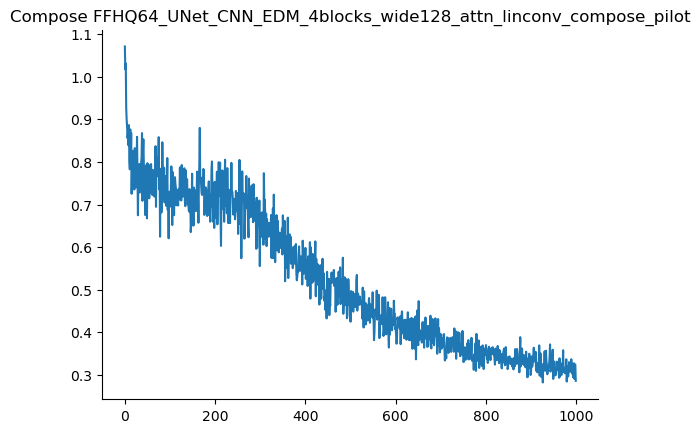

In [43]:
plt.plot(loss_traj)
plt.title(f"Compose {expname}")
plt.savefig(join(savedir, f"loss_traj_{expname}.png"))
plt.show()

pkl.dump(loss_traj, open(join(savedir, f"loss_traj_{expname}.pkl"), "wb"))

### Directly adding the patch conv solution to the previous denoiser

In [44]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_Add_pilot"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
for folder in [savedir, ckptdir, sample_dir]:
    os.makedirs(folder, exist_ok=True)
# cov_empirical = torch.cov(pnts.T, correction=1)
# print(f"{args.dataset_name} dataset {pnts.shape[0]} samples, {ndim} features")
# config = edict(
#     channels=imgchannels,
#     img_size=imgsize,
#     layers_per_block=layers_per_block,
#     decoder_init_attn=decoder_init_attn,
#     attn_resolutions=attn_resolutions,
#     model_channels=model_channels,
#     channel_mult=channel_mult,
#     dropout=0.0,
#     label_dim=0,
#     augment_dim=0,
# )
pprint(config)

# json.dump(config, open(f"{savedir}/config.json", "w"))
# json.dump(args.__dict__, open(f"{savedir}/args.json", "w"))
lr = 1e-4
nsteps = 1000
batch_size = 32
record_frequency = 10
save_ckpts = False
ckpt_dir = ckptdir
ckpt_step_list = []
sampling_callback_fn = None
record_times = []
unet = create_unet_model(config)
# model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
model_precd = EDMCNNPrecondLinConvAddWrapper(unet, adaptive_denoiser, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=lr, nepochs=nsteps, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=record_frequency, callback_step_list=record_times,
                                    save_ckpts=save_ckpts, ckpt_dir=ckpt_dir, save_ckpt_step_list=ckpt_step_list)

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 64,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 16.288


Directly adding it is not helping the score! very bad. Need better preconditioning

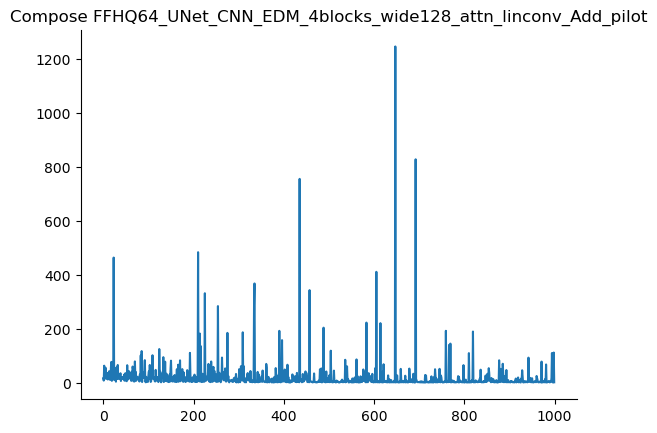

In [45]:
plt.plot(loss_traj)
plt.title(f"Compose {expname}")
plt.savefig(join(savedir, f"loss_traj_{expname}.png"))
plt.show()

pkl.dump(loss_traj, open(join(savedir, f"loss_traj_{expname}.pkl"), "wb"))

In [49]:
torch.cuda.empty_cache()

In [50]:
del unet
torch.cuda.empty_cache()

In [51]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_Add_NoSkip_pilot"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
for folder in [savedir, ckptdir, sample_dir]:
    os.makedirs(folder, exist_ok=True)
# cov_empirical = torch.cov(pnts.T, correction=1)
# print(f"{args.dataset_name} dataset {pnts.shape[0]} samples, {ndim} features")
# config = edict(
#     channels=imgchannels,
#     img_size=imgsize,
#     layers_per_block=layers_per_block,
#     decoder_init_attn=decoder_init_attn,
#     attn_resolutions=attn_resolutions,
#     model_channels=model_channels,
#     channel_mult=channel_mult,
#     dropout=0.0,
#     label_dim=0,
#     augment_dim=0,
# )
pprint(config)

# json.dump(config, open(f"{savedir}/config.json", "w"))
# json.dump(args.__dict__, open(f"{savedir}/args.json", "w"))
lr = 1e-4
nsteps = 1000
batch_size = 32
record_frequency = 10
save_ckpts = False
ckpt_dir = ckptdir
ckpt_step_list = []
sampling_callback_fn = None
record_times = []
unet = create_unet_model(config)
# model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
model_precd = EDMCNNPrecondLinConvAddNoSkipWrapper(unet, adaptive_denoiser, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=lr, nepochs=nsteps, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=record_frequency, callback_step_list=record_times,
                                    save_ckpts=save_ckpts, ckpt_dir=ckpt_dir, save_ckpt_step_list=ckpt_step_list)

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 64,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 0.274


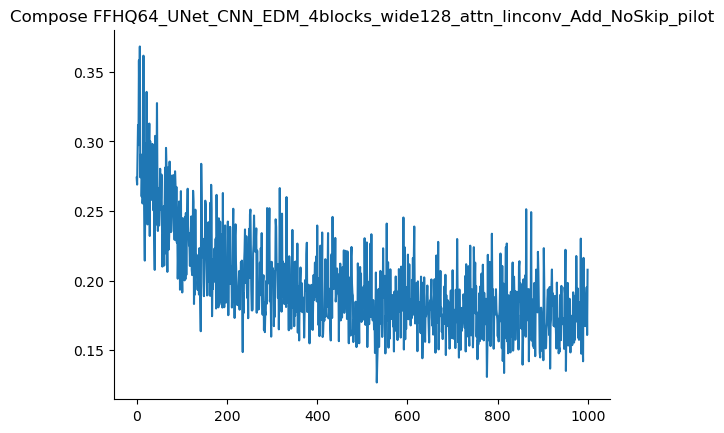

In [52]:
plt.plot(loss_traj)
plt.title(f"Compose {expname}")
plt.savefig(join(savedir, f"loss_traj_{expname}.png"))
plt.show()

pkl.dump(loss_traj, open(join(savedir, f"loss_traj_{expname}.pkl"), "wb"))

In [53]:
del unet, model_precd
torch.cuda.empty_cache()

### Baseline version, No patch conv

In [54]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_baseline_pilot"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
for folder in [savedir, ckptdir, sample_dir]:
    os.makedirs(folder, exist_ok=True)
# cov_empirical = torch.cov(pnts.T, correction=1)
# print(f"{args.dataset_name} dataset {pnts.shape[0]} samples, {ndim} features")
# config = edict(
#     channels=imgchannels,
#     img_size=imgsize,
#     layers_per_block=layers_per_block,
#     decoder_init_attn=decoder_init_attn,
#     attn_resolutions=attn_resolutions,
#     model_channels=model_channels,
#     channel_mult=channel_mult,
#     dropout=0.0,
#     label_dim=0,
#     augment_dim=0,
# )
pprint(config)

# json.dump(config, open(f"{savedir}/config.json", "w"))
# json.dump(args.__dict__, open(f"{savedir}/args.json", "w"))
lr = 1e-4
nsteps = 1000
batch_size = 32
record_frequency = 10
save_ckpts = False
ckpt_dir = ckptdir
ckpt_step_list = []
sampling_callback_fn = None
record_times = []
unet = create_unet_model(config)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
# model_precd = EDMCNNPrecondLinConvAddNoSkipWrapper(unet, adaptive_denoiser, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=lr, nepochs=nsteps, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=record_frequency, callback_step_list=record_times,
                                    save_ckpts=save_ckpts, ckpt_dir=ckpt_dir, save_ckpt_step_list=ckpt_step_list)

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 64,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 1.078


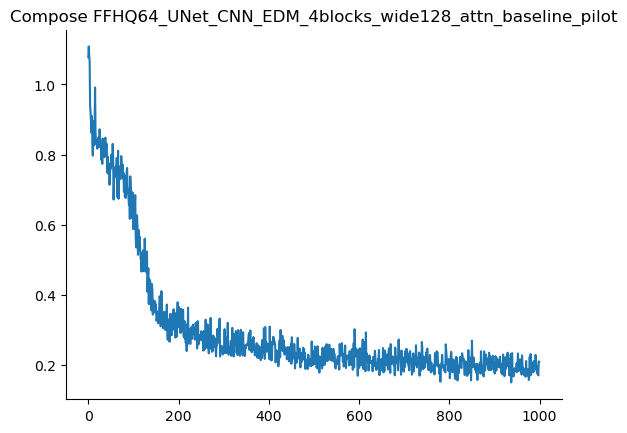

In [55]:
plt.plot(loss_traj)
plt.title(f"Compose {expname}")
plt.savefig(join(savedir, f"loss_traj_{expname}.png"))
plt.show()

pkl.dump(loss_traj, open(join(savedir, f"loss_traj_{expname}.pkl"), "wb"))

### Synopsis pull the four different loss_traj and compare

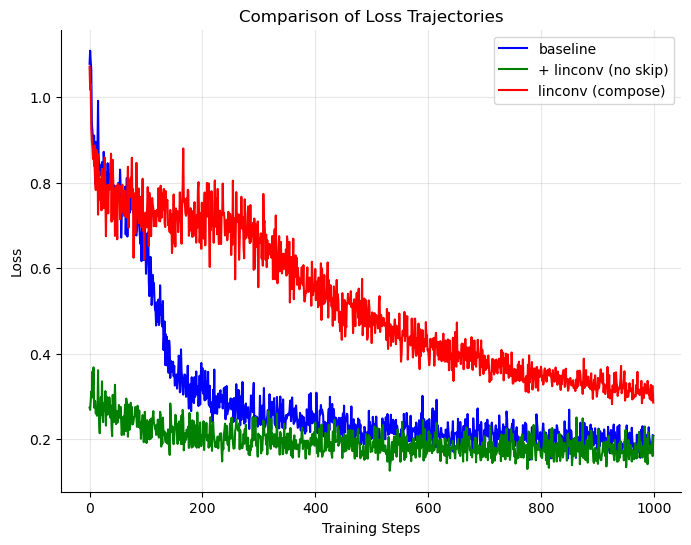

In [61]:
# Load and compare the loss trajectories from different experiments
import os
import pickle as pkl
import matplotlib.pyplot as plt

# Define the experiments to compare
experiments = [
    # "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain",  # UNet
    ("baseline", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_baseline_pilot"),  # Adaptive Linear Conv
    ("+ linconv (no skip)", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_Add_NoSkip_pilot"),  # Combined
    ("linconv (compose)", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_compose_pilot"),  # Current experiment
    # ("+ linconv", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_Add_pilot"),  # Current experiment
]

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
labels = ['baseline', '+ linconv (no skip)', 'linconv (compose)'] # '+ linconv', 
for i, (label, exp) in enumerate(experiments):
    try:
        loss_path = join(saveroot, exp, f"loss_traj_{exp}.pkl")
        if os.path.exists(loss_path):
            loss = pkl.load(open(loss_path, "rb"))
            plt.plot(loss, color=colors[i], label=label)
        else:
            print(f"Loss trajectory file not found for {exp}")
    except Exception as e:
        print(f"Error loading loss trajectory for {exp}: {e}")

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Comparison of Loss Trajectories')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(join(savedir, "loss_comparison.png"))
plt.show()

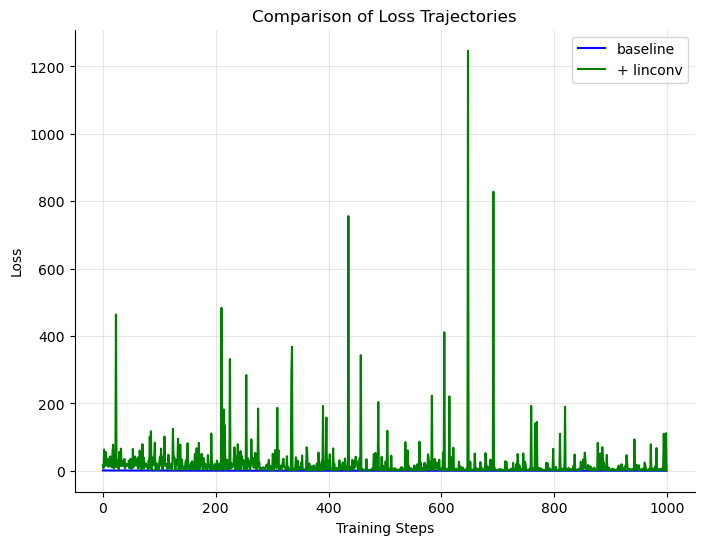

In [62]:
# Load and compare the loss trajectories from different experiments
import os
import pickle as pkl
import matplotlib.pyplot as plt

# Define the experiments to compare
experiments = [
    # "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain",  # UNet
    ("baseline", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_baseline_pilot"),  # Adaptive Linear Conv
    # ("+ linconv (no skip)", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_Add_NoSkip_pilot"),  # Combined
    # ("linconv (compose)", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_compose_pilot"),  # Current experiment
    ("+ linconv", "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_linconv_Add_pilot"),  # Current experiment
]

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
labels = ['baseline', '+ linconv (no skip)', 'linconv (compose)'] # '+ linconv', 
for i, (label, exp) in enumerate(experiments):
    try:
        loss_path = join(saveroot, exp, f"loss_traj_{exp}.pkl")
        if os.path.exists(loss_path):
            loss = pkl.load(open(loss_path, "rb"))
            plt.plot(loss, color=colors[i], label=label)
        else:
            print(f"Loss trajectory file not found for {exp}")
    except Exception as e:
        print(f"Error loading loss trajectory for {exp}: {e}")

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Comparison of Loss Trajectories')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(join(savedir, "loss_comparison.png"))
plt.show()

### Comparison with UNet 

In [10]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain"
savedir = join(saveroot, expname)
ckptdir = join(savedir, "ckpts")
sample_dir = join(savedir, "samples")
linconv_dir = join(savedir, "linconv_results")
os.makedirs(linconv_dir, exist_ok=True)
config = edict(json.load(open(f"{savedir}/config.json")))
args = edict(json.load(open(f"{savedir}/args.json")))
pprint(config)
unet = create_unet_model(config)
CNN_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

ckpt_step_list = find_all_ckpt_steps(ckptdir)
CNN_precd.load_state_dict(torch.load(join(ckptdir, f"model_epoch_{ckpt_step_list[-1]:06d}.pth")))

{'attn_resolutions': [8],
 'augment_dim': 0,
 'channel_mult': [1, 2, 2, 2],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 64,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Found 169 checkpoints in the directory, largest step is 220643


<All keys matched successfully>